<center> <h1>Perturbation Analysis </h1> </center>

&nbsp;

&nbsp;

In this notebook, we investigate the  ability of the **GraphWave** algorithm to detect structural similarities, as well as its robustness to small perturbations. We propose an analysis of the accuracy of the recovery of the different topological roles based on simulations on toy graphs, so that we benefit from an actual ground-truth to benchmark the different results. For convenience purposes, this notebook contains code for running the "perturbed" experiments provided in the associated paper. We have tested here "small pertubations" (we randomly add a few edges to the structure, so as to  maintain the patterns (this is why we did not delete edges as well), but shattering the symmetry of the system that yielded structural equivalents. For simulations with a higher noise level, we refer the reader to Notebook Synthetic Experiments--structures.

The setup of the experiment is the following:

1. We begin by creating a toy graph (that is, a regular structure with repetitions of identical patterns at different areas of the graph). Each type of structural role (that is, bottom corner in the house shape, middle of the center ring, etc.) is endowed with a particular label.
2. __Optional__: to simulate the effect of small perturbations, we artificially remove and add a few edges on the graph
3. We compute the structural representations given by our method
4. To assess the relevance of our results, we propose to evaluate our method using 3 different criteria:
    + We project these representations in 2D using PCA: the idea is to try to assess visually the proximity of the different featurization. In the different plots,
    + We also plug-in these representations as input into a clustering algorithm (default: kmeans), and assess the purity of the clusters that are recovered using k-means. This gives us an indicator of the relevance of our embeddings if the goal was to recover $K$ distinct classes of structural equivalents.


First of all, to provide a little bit of intuition and to explain some of the follwoing results, we note that RoleX is specifically designed for clustering role similarities, whereas struc2vec and GraphWave aim to find similarities across a spectrum of roles (hence the distance between nodes is more meaningful in the later than in the case of RoleX), which does not guarantee to provide comparisons across classes. Hence, since we propose to assess the performance via clustering, RoleX should perform better --it was designed specifically for this purpose.

## I. Loading the modules and creating the graph

In [3]:
%matplotlib inline

import sys, os
fp = os.path.abspath('./docker/src/python/experiments/graphwave/graphwave')
if fp not in sys.path: sys.path.insert(0,fp)

#### Tests like paper
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np
import pandas as pd
import pickle
import seaborn as sb
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import sys

sys.path.append('../')
import graphwave as gw
from shapes.shapes import *
from shapes.build_graph import *
# from distances.distances_signature import *
from characteristic_functions import *


In [4]:
# 1- Start by defining our favorite regular structure

width_basis = 15
nbTrials = 20


################################### EXAMPLE TO BUILD A SIMPLE REGULAR STRUCTURE ##########
## REGULAR STRUCTURE: the most simple structure:  basis + n small patterns of a single type

### 1. Choose the basis (cycle, torus or chain)
basis_type = "cycle" 

### 2. Add the shapes 
nb_shapes = 5  ## numbers of shapes to add 
#shape = ["fan",6] ## shapes and their associated required parameters  (nb of edges for the star, etc)
#shape = ["star",6]
list_shapes = [["house"]] * nb_shapes

### 3. Give a name to the graph
identifier = 'AA'  ## just a name to distinguish between different trials
name_graph = 'houses' + identifier
sb.set_style('white')

### 4. Pass all these parameters to the Graph Structure
add_edges = 4 ## nb of edges to add anywhere in the structure
del_edges  =0

G, communities, plugins, role_id = build_structure(width_basis, basis_type, list_shapes, start=0,
                            rdm_basis_plugins =False, add_random_edges=0,
                            plot=False, savefig=False)

In [6]:
print('nb of nodes in the graph: ', G.number_of_nodes())
print('nb of edges in the graph: ', G.number_of_edges())

nb of nodes in the graph:  40
nb of edges in the graph:  60


## Start the analysis!!

In this first set of experiments, we look at the performance of the algorithms when 3 edges are randomly added to the structure. This provides a "small perturbation", since the Jaccard distance between the adjacency matrices of the two graphs is:
$$ d_{HAmming}(A, \tilde{A})=\frac{||A -\tilde{A}||_2}{||A +\tilde{A}||_*}=\frac{6}{63*2}=0.048$$

We iterate the experiment 20 times, and average over the performance score to finally be able to compare the algorithms. 

We have included the results of this experiments in the cache folder, which the reader can either download or run again.


In [9]:
from graphwave import graphwave_alg
chi,heat_print, taus = graphwave_alg(G, np.linspace(0,100,25), taus=range(19,21), verbose=True)
mapping_inv={i: taus[i] for i in range(len(taus))}
mapping={float(v): k for k,v in mapping_inv.items()}

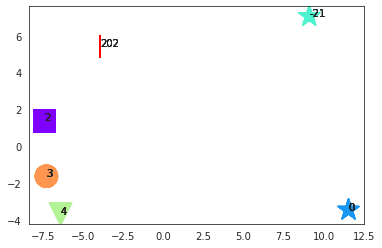

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

colors = role_id
nb_clust = len(np.unique(colors))
pca = PCA(n_components=5)

trans_data = pca.fit_transform(StandardScaler().fit_transform(chi))
km = sk.cluster.KMeans(n_clusters=nb_clust)
km.fit(trans_data)
labels_pred = km.labels_
######## Params for plotting
cmapx = plt.get_cmap('rainbow')
x = np.linspace(0,1,np.max(labels_pred) + 1)
col = [cmapx(xx) for xx in x ]
markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,\
           9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,\
           18:2,19:6,20:7}
########

for c in np.unique(colors):
        indc = [i for i, x in enumerate(colors) if x == c]
        #print indc
        plt.scatter(trans_data[indc, 0], trans_data[indc, 1],
                    c=np.array(col)[list(np.array(labels_pred)[indc])],
                    marker=markers[c%len(markers)], s=500)
labels = colors
for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
            plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
            

In [13]:
ami=sk.metrics.adjusted_mutual_info_score(colors, labels_pred)  
sil=sk.metrics.silhouette_score(trans_data,labels_pred, metric='euclidean')
ch=sk.metrics.calinski_harabasz_score(trans_data, labels_pred)
hom=sk.metrics.homogeneity_score(colors, labels_pred) 
comp=sk.metrics.completeness_score(colors, labels_pred)
print('Homogeneity \t Completeness \t AMI \t nb clusters \t CH \t  Silhouette \n')
print(str(hom)+'\t'+str(comp)+'\t'+str(ami)+'\t'+str(nb_clust)+'\t'+str(ch)+'\t'+str(sil))


Homogeneity 	 Completeness 	 AMI 	 nb clusters 	 CH 	  Silhouette 

1.0	1.0	1.0	6	3.132091060885324e+31	0.9999999917172353


## II. Varied shapes

In [14]:
from sklearn.manifold import TSNE
################################### EXAMPLE TO BUILD A MORE COMPLICATED STRUCTURE ##########
######### Alternatively, to define a structure with different types of patterns, pass them as a list
######### In the following example, we have 3 fans (with param. 6), 3 stars on 4 nodes, and 3 house shapes
name_graph='regular'
from sklearn import preprocessing
width_basis=25
add_edges=10
list_shapes=[["fan",6]]*5+[["star",10]]*5+[["house"]]*5 
G,colors_shape, plugins,colors=build_structure(width_basis,basis_type,list_shapes, start=0,add_random_edges=add_edges,plot=False,savefig=False)
nb_clust=len(np.unique(colors))
chi,heat_print, taus = graphwave_alg(G, np.linspace(0,100,25), taus='auto', verbose=True)




76 66
86 111
54 39
77 84
28 48
100 132
80 111
77 46
41 100
62 90


Homogeneity 	 Completeness 	 AMI 	 nb clusters 	 CH 	  Silhouette 

0.8451592991778187	0.8053235550495138	0.7693835112059886	14	214.14333807106468	0.6156015869709708


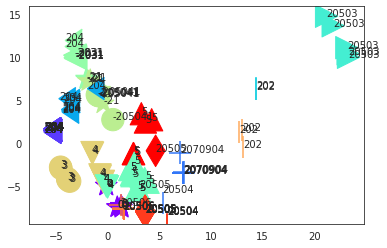

In [16]:
pca=PCA(n_components=5)
trans_data=pca.fit_transform(StandardScaler().fit_transform(chi))
km=sk.cluster.KMeans(n_clusters=nb_clust)
km.fit(trans_data)
labels_pred=km.labels_
######## Params for plotting
cmapx=plt.get_cmap('rainbow')
x=np.linspace(0,1,np.max(labels_pred)+1)
col=[cmapx(xx) for xx in x ]
markers = {0:'*',1: '.', 2:',',3: 'o',4: 'v',5: '^',6: '<',7: '>',8: 3 ,9:'d',10: '+',11:'x',12:'D',13: '|',14: '_',15:4,16:0,17:1,18:2,19:6,20:7}
########

for c in np.unique(colors):
        indc=[i for i,x in enumerate(colors) if x==c]
        #print indc
        plt.scatter(trans_data[indc,0], trans_data[indc,1],c=np.array(col)[list(np.array(labels_pred)[indc])] ,marker=markers[c%len(markers)],s=500)
labels = colors
for label,c, x, y in zip(labels,labels_pred, trans_data[:, 0], trans_data[:, 1]):
            plt.annotate(label,xy=(x, y), xytext=(0, 0), textcoords='offset points')
            

ami=sk.metrics.adjusted_mutual_info_score(colors, labels_pred)  
sil=sk.metrics.silhouette_score(trans_data,labels_pred, metric='euclidean')
ch=sk.metrics.calinski_harabasz_score(trans_data, labels_pred)
hom=sk.metrics.homogeneity_score(colors, labels_pred) 
comp=sk.metrics.completeness_score(colors, labels_pred)
print('Homogeneity \t Completeness \t AMI \t nb clusters \t CH \t  Silhouette \n')
print(str(hom)+'\t'+str(comp)+'\t'+str(ami)+'\t'+str(nb_clust)+'\t'+str(ch)+'\t'+str(sil))